In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Drop rows where the target variable is NaN
train_data = train_data.dropna(subset=['price'])

# Remove outliers based on IQR
Q1 = train_data['price'].quantile(0.25)
Q3 = train_data['price'].quantile(0.75)
IQR = Q3 - Q1
filter = (train_data['price'] >= Q1 - 1.5 * IQR) & (train_data['price'] <= Q3 + 1.5 * IQR)
train_data = train_data.loc[filter]

# Define the feature columns based on your dataset
numerical_features = ['milage']
categorical_features = ['brand', 'model', 'fuel_type','model_year','engine','transmission','ext_col','int_col','accident','clean_title']

# Define the target variable and features
X = train_data.drop('price', axis=1)
y = train_data['price']
X_test = test_data

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data and convert to dense arrays
X_train = preprocessor.fit_transform(X)
X_test = preprocessor.transform(X_test)

# Convert sparse matrices to dense arrays
X_train = X_train.toarray()
X_test = X_test.toarray()

# Split the preprocessed data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.2, random_state=42)


In [ ]:
!pip install keras-tuner --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units1', min_value=32, max_value=512, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout1', 0, 0.5, step=0.1)))

    model.add(keras.layers.Dense(
        units=hp.Int('units2', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout2', 0, 0.5, step=0.1)))

    model.add(keras.layers.Dense(
        units=hp.Int('units3', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout3', 0, 0.5, step=0.1)))

    model.add(keras.layers.Dense(1))  # Output layer (no activation for regression)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

# Initialize the tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,  # Limit the number of trials to 40
    executions_per_trial=1,  # Number of times to repeat each trial for robustness
    directory='my_dir',
    project_name='car_price_optimization'
)

# Perform the search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

# Get the best model
#best_model = tuner.get_best_models(num_models=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 03m 24s]
val_mean_squared_error: 124518448.0

Best val_mean_squared_error So Far: 123898616.0
Total elapsed time: 00h 31m 56s


Epoch 1/100
1280/1280 [==============================] - 5s 4ms/step - loss: 103139648.0000 - mean_squared_error: 103139648.0000 - val_loss: 132439704.0000 - val_mean_squared_error: 132439704.0000
Epoch 2/100
1280/1280 [==============================] - 6s 5ms/step - loss: 102875872.0000 - mean_squared_error: 102875872.0000 - val_loss: 133265448.0000 - val_mean_squared_error: 133265448.0000
Epoch 3/100
1280/1280 [==============================] - 5s 4ms/step - loss: 103449872.0000 - mean_squared_error: 103449872.0000 - val_loss: 132382360.0000 - val_mean_squared_error: 132382360.0000
Epoch 4/100
1280/1280 [==============================] - 6s 5ms/step - loss: 102782352.0000 - mean_squared_error: 102782352.0000 - val_loss: 132929400.0000 - val_mean_squared_error: 132929400.0000
Epoch 5/100
1280/1280 [==============================] - 5s 4ms/step - loss: 103091608.0000 - mean_squared_error: 103091608.0000 - val_loss: 133096368.0000 - val_mean_squared_error: 133096368.0000
Epoch 6/100
128

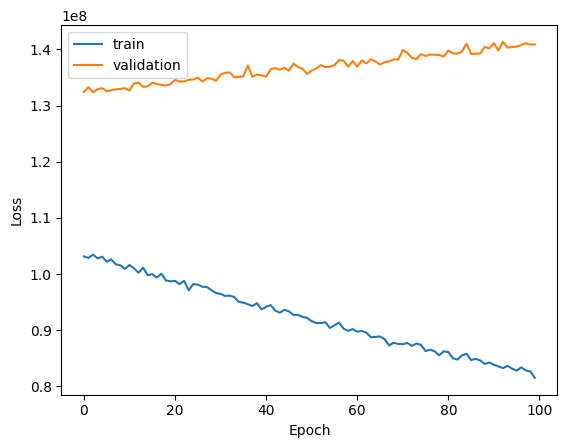

1131/1131 [==============================] - 2s 2ms/step


In [ ]:
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on the test set
test_predictions = best_model.predict(X_test).flatten()

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': test_predictions
})

# Save submission to CSV
submission.to_csv('submission_optimized_deep_learning.csv', index=False)


In [ ]:
# Make predictions on the test set
test_predictions = best_model.predict(X_test).flatten()

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': test_predictions
})

# Save submission to CSV
submission.to_csv('submission_optimized_deep_learning.csv', index=False)


In [ ]:
train_preds = model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))

valid_preds = model.predict(X_valid_scaled)
valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))

print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {valid_rmse}")

# Once satisfied with the model performance, prepare for submission
test_data = pd.read_csv('test.csv')  # Adjust this based on your actual file path

# Perform necessary preprocessing steps on test_data
test_data_numeric = test_data[numeric_cols]  # Replace numeric_cols with your numeric columns

# Scale test data using the same scaler as used for training data
X_test_scaled = scaler.transform(test_data_numeric)  # Assuming 'scaler' is your StandardScaler object

# Make predictions using your best deep learning model
test_predictions = model.predict(X_test_scaled)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],  # Assuming 'id' is the column name for identifiers in test_data
    'price': test_predictions.flatten()  # Assuming 'price' is the predicted column name
})

# Save submission to CSV
submission.to_csv('submission_deep_learning_improved.csv', index=False)

340/340 [==============================] - 1s 2ms/step
Training RMSE: 73574.38275153922
Validation RMSE: 49534.72107417636


NameError: name 't' is not defined

In [ ]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)  # Output layer (no activation for regression)
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mean_squared_error'])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               437376    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 445697 (1.70 MB)
Trainable params: 445697 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,  # Number of epochs (iterations over the entire dataset)
                    batch_size=32,  # Number of samples per gradient update
                    validation_data=(X_valid, y_valid),
                    verbose=1)  # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)


Epoch 1/50
1357/1357 [==============================] - 13s 9ms/step - loss: 6264503296.0000 - mean_squared_error: 6264503296.0000 - val_loss: 2622822400.0000 - val_mean_squared_error: 2622822400.0000
Epoch 2/50
1357/1357 [==============================] - 12s 9ms/step - loss: 5535434752.0000 - mean_squared_error: 5535434752.0000 - val_loss: 2500258560.0000 - val_mean_squared_error: 2500258560.0000
Epoch 3/50
1357/1357 [==============================] - 12s 9ms/step - loss: 5457206784.0000 - mean_squared_error: 5457206784.0000 - val_loss: 2447903488.0000 - val_mean_squared_error: 2447903488.0000
Epoch 4/50
1357/1357 [==============================] - 11s 8ms/step - loss: 5410735104.0000 - mean_squared_error: 5410735104.0000 - val_loss: 2414909952.0000 - val_mean_squared_error: 2414909952.0000
Epoch 5/50
1357/1357 [==============================] - 11s 8ms/step - loss: 5385222144.0000 - mean_squared_error: 5385222144.0000 - val_loss: 2388527616.0000 - val_mean_squared_error: 2388527616.

In [ ]:
# Make predictions on the test set
test_predictions = model.predict(X_test).flatten()

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': test_predictions
})

# Save submission to CSV
submission.to_csv('submission_deep_learning.csv', index=False)


1131/1131 [==============================] - 3s 2ms/step
